### 0. Importar librerías

In [1]:
import pandas as pd
import numpy as np

# Se define la semilla para que cuando se vuelva a ejecutar el split train-test
# los datos que contiene cada conjunto sean los mismos
semilla = 1234

---

# 1. Cargar el dataset

In [2]:
# Ruta del fichero del dataset sin filtrar
path = 'datos/datos.csv'

# Cargar el dataset
datos = pd.read_csv(path)

# Al ser un dataset pequeño se muestra completo
datos

,AF365,AF450,35 deg,42 deg,Grupo
0,2.320158,1.229614,13.01,19.39,0
1,1.529274,0.616514,8.18,24.78,0
2,1.908257,0.955847,7.75,16.90,0
3,1.590625,1.018495,4.10,16.30,0
4,1.617071,1.242961,5.76,21.05,0
...,...,...,...,...,...
119,4.093525,3.037288,3.97,5.35,2
120,4.730000,3.040000,7.04,14.44,2
121,4.010000,4.110000,6.65,17.37,2
122,3.200000,2.360000,6.70,10.57,2


In [3]:
# Contar el número de instancias de cada grupo
datos['Grupo'].value_counts()

1    62
0    48
2    14
Name: Grupo, dtype: int64

## Preparar conjuntos de entrenamiento (80%) y test (20%)

In [4]:
# Se separa la variable a predecir (Grupo)
X = datos.drop('Grupo', axis=1)
y = datos['Grupo']

In [5]:
# Importar librería de scikit-learn para separar los datos
from sklearn.model_selection import train_test_split

# Separar datos en conjunto de entrenamiento (80%) y test (20%) de manera estratificada
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=semilla)

In [6]:
# Visualizar la dimensión de los datos separados
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (99, 4)
Training Labels Shape: (99,)
Testing Features Shape: (25, 4)
Testing Labels Shape: (25,)


In [7]:
# Distribución de los grupos en el conjunto de entrenamiento
y_train.value_counts()

1    50
0    38
2    11
Name: Grupo, dtype: int64

In [8]:
# Valores normalizados
y_train.value_counts(normalize=True)

1    0.505051
0    0.383838
2    0.111111
Name: Grupo, dtype: float64

In [9]:
# Distribución de los grupos en el conjunto de test
y_test.value_counts()

1    12
0    10
2     3
Name: Grupo, dtype: int64

In [10]:
# Valores normalizados
y_test.value_counts(normalize=True)

1    0.48
0    0.40
2    0.12
Name: Grupo, dtype: float64

### Visualizar distribución de cada conjunto (entrenamiento y test)

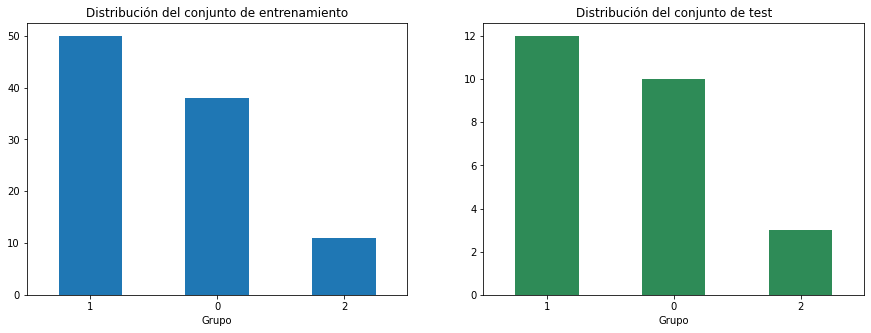

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,5))

#fig.suptitle("Distribución de los grupos en los conjuntos de entrenamiento y test")

# Representación del conjunto de entrenamiento
plt.subplot(121)
y_train.value_counts().plot(kind='bar')
plt.title('Distribución del conjunto de entrenamiento')
plt.xlabel('Grupo')
plt.xticks(rotation=0)

# Representación del conjunto de test
plt.subplot(122)
y_test.value_counts().plot(kind='bar', color='seagreen')
plt.title('Distribución del conjunto de test')
plt.xlabel('Grupo')
plt.xticks(rotation=0)

plt.show()

---

# 2. Crear el modelo

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import multiprocessing

# Definición del modelo
modelo = KNeighborsClassifier()

# Definición de parámetros de búsqueda
parametros = {'n_neighbors': np.arange(1,10,2),
              'weights'    : ['uniform', 'distance'],
              'algorithm'  : ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size'  : np.arange(10,51,10)}

# Definición de los folds estratificados
folds = StratifiedKFold(n_splits=8, shuffle=True, random_state=semilla)

# Búsqueda de parámetros
grid = GridSearchCV(
    estimator  = modelo,
    param_grid = parametros,
    scoring    = 'accuracy',
    n_jobs     = multiprocessing.cpu_count() - 1,
    cv         = folds,
    verbose    = 0,
    return_train_score = True
    )

# Entrenamiento
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=1234, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=7,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': array([10, 20, 30, 40, 50]),
                         'n_neighbors': array([1, 3, 5, 7, 9]),
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='accuracy')

In [13]:
# Visualización de los resultados de la búsqueda ordenados de mejor a peor
df_resultados = pd.DataFrame(grid.cv_results_)
df_resultados = df_resultados.sort_values(by=['rank_test_score'])
df_resultados[['params', 'rank_test_score', 'mean_test_score', 'std_test_score']].head()

,params,rank_test_score,mean_test_score,std_test_score
48,"{'algorithm': 'auto', 'leaf_size': 50, 'n_neig...",1,0.778045,0.077716
118,"{'algorithm': 'kd_tree', 'leaf_size': 20, 'n_n...",1,0.778045,0.077716
198,"{'algorithm': 'brute', 'leaf_size': 50, 'n_nei...",1,0.778045,0.077716
128,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'n_n...",1,0.778045,0.077716
98,"{'algorithm': 'ball_tree', 'leaf_size': 50, 'n...",1,0.778045,0.077716


In [14]:
# Se muestran los mejores parámetros
print('Mejores parámetros: ', grid.best_params_)

Mejores parámetros:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 9, 'weights': 'uniform'}


In [15]:
# Se visualiza la exactitud (accuracy) del entrenamiento para compararlo con el que se obtenga en la evaluación
print(grid.best_score_)

0.7780448717948718


In [16]:
# Se toma el modelo que ha obtenido el mejor resultado
modelo_knn = grid.best_estimator_

---

# 3. Evaluar el modelo

In [17]:
# Se lleva a cabo la predicción para evaluar el modelo
y_pred = modelo_knn.predict(X_test)

In [18]:
# Visualización de las predicciones
print(y_pred)

[1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1]


## Matriz de confusión

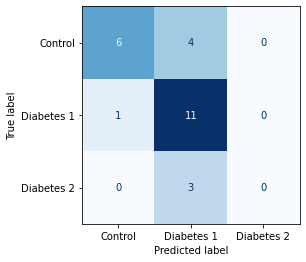

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_test, y_pred)
# Filas: valores reales
# Columnas: predicción

clases = ['Control', 'Diabetes 1', 'Diabetes 2']

# Visualización de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)

disp.plot(cmap='Blues', colorbar=False)
plt.show()

## Classification report

In [20]:
clases = ['Control', 'Diabetes 1', 'Diabetes 2']

print(classification_report(y_test,
                            y_pred,
                            target_names=clases,
                            digits=4,
                            zero_division=0))

# El parámetro zero_division no muestra warnings cuando se vaya a realizar una división por 0 al calcular alguna métrica

              precision    recall  f1-score   support

     Control     0.8571    0.6000    0.7059        10
  Diabetes 1     0.6111    0.9167    0.7333        12
  Diabetes 2     0.0000    0.0000    0.0000         3

    accuracy                         0.6800        25
   macro avg     0.4894    0.5056    0.4797        25
weighted avg     0.6362    0.6800    0.6344        25



Se calcula la __especificidad__ a partir de la clase _multilabel_confusion_matrix_. Se van a obtener también el resto de métricas con las obtenidas en el _classification report_ para comprobar que son correctas.

Código basado en la documentación de scikit-learn: https://scikit-learn.org/stable/modules/model_evaluation.html#multilabel-confusion-matrix

In [21]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

# Se obtiene la matriz de confusión de cada clase
cm_multi = multilabel_confusion_matrix(y_test, y_pred)

# Se obtienen los valores de TN, TP, FN y FP de cada clase
tn = cm_multi[:, 0, 0]
tp = cm_multi[:, 1, 1]
fn = cm_multi[:, 1, 0]
fp = cm_multi[:, 0, 1]

# Se calculan las métricas (array de dimensión 3 con la métrica para cada clase)
accuracy    = accuracy_score(y_test, y_pred)
precision   = tp / (tp + fp)
recall      = tp / (tp + fn)
specificity = tn / (tn + fp)
f1          = (2 * precision * recall) / (precision + recall)

# Visualizar la exactitud del modelo
print("----------------------")
print("Exactitud: \t{:.4f}".format(accuracy))
print("----------------------")
print("")

# Visualizar la métrica precision para cada clase y la global (macro avg)
print("----------------------")
print("      Precisión       ")
print("----------------------")
print("Control: \t{:.4f}".format(precision[0]))
print("Diabetes 1: \t{:.4f}".format(precision[1]))
print("Diabetes 2: \t{:.4f}".format(precision[2]))
print("MACRO AVG: \t{:.4f}".format(precision.mean()))
print("")

# Visualizar la sensibilidad para cada clase y la global (macro avg)
print("----------------------")
print("     Sensibilidad     ")
print("----------------------")
print("Control: \t{:.4f}".format(recall[0]))
print("Diabetes 1: \t{:.4f}".format(recall[1]))
print("Diabetes 2: \t{:.4f}".format(recall[2]))
print("MACRO AVG: \t{:.4f}".format(recall.mean()))
print("")

# Visualizar la especificidad para cada clase y la global (macro avg)
print("----------------------")
print("    Especificidad     ")
print("----------------------")
print("Control: \t{:.4f}".format(specificity[0]))
print("Diabetes 1: \t{:.4f}".format(specificity[1]))
print("Diabetes 2: \t{:.4f}".format(specificity[2]))
print("MACRO AVG: \t{:.4f}".format(specificity.mean()))
print("")

# Visualizar la mátrica F1 para cada clase y la global (macro avg)
print("----------------------")
print("       F1-score       ")
print("----------------------")
print("Control: \t{:.4f}".format(f1[0]))
print("Diabetes 1: \t{:.4f}".format(f1[1]))
print("Diabetes 2: \t{:.4f}".format(f1[2]))
print("MACRO AVG: \t{:.4f}".format(f1.mean()))
print("")

----------------------
Exactitud: 	0.6800
----------------------

----------------------
      Precisión       
----------------------
Control: 	0.8571
Diabetes 1: 	0.6111
Diabetes 2: 	nan
MACRO AVG: 	nan

----------------------
     Sensibilidad     
----------------------
Control: 	0.6000
Diabetes 1: 	0.9167
Diabetes 2: 	0.0000
MACRO AVG: 	0.5056

----------------------
    Especificidad     
----------------------
Control: 	0.9333
Diabetes 1: 	0.4615
Diabetes 2: 	1.0000
MACRO AVG: 	0.7983

----------------------
       F1-score       
----------------------
Control: 	0.7059
Diabetes 1: 	0.7333
Diabetes 2: 	nan
MACRO AVG: 	nan



C:\Users\Alberto\AppData\Local\Temp/ipykernel_4936/1740227734.py:14: RuntimeWarning: invalid value encountered in true_divide
  precision   = tp / (tp + fp)
